<a href="https://colab.research.google.com/github/compi1234/pyspch/blob/master/test/audio_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Audio Test Notebook 

This notebook demonstrates essential Audio I/O utilities provided in the **pyspch.audio** module
- loading audio data from file   
- play audio
- recording audio; can be done via direct control of the sounddevice or using javascript in the browser

Date: 11/04/2021, 13/05/2021, 24/05/21

In [1]:
%matplotlib inline
from IPython.display import display, clear_output, Audio, HTML
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

import librosa
try:
  import google.colab
  IN_COLAB = True 
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False

# verify the IPython version
import IPython
if IPython.version_info[0] >= 6:
    Audio_args = {'normalize':False}
else:
    print("Warning: you are using IPython<6 \n IPython.display.Audio() will automatically normalize audio output")
    Audio_args = {}
import pyspch.audio as audio
import pyspch.spectrogram as specg
import pyspch.utils as spch_utils
import pyspch.display as spch_disp
#import pyspch.display_ly as spch_disp
import pyspch

SAMPLE_WAV_URL = 'https://homes.esat.kuleuven.be/~spchlab/data/misc/train.wav'
SAMPLE_WAV_13dB_SNGER = 'https://homes.esat.kuleuven.be/~spchlab/data/13dB/Psnger22.wav'

### 1. Your Sound Device (local) - querrying & setting basic properties

Sounddevice properties are either common for input/output or specified as a list [ input, output ]  
Hardware information and Factory settings are accessible via soundevice.qeury_devices() and souddevice.hostapis().  
Current settings are given in souddevice.default object   
Checking if your input or output devices can handle a request can be done via sounddevice.check_input_settings()

For speech processing you may want to set 
- sounddevice.default.samplerate = 16000    (applied to both input and output)
- sounddevice.default.channels = 1          (you can set different values for input,output )

In [ ]:
# Hardware info and factory settings, defaults
print("Sounddevice: ",sd.__version__)
print("PortAudio: ", sd.get_portaudio_version())
print("Available Devices: "); print(sd.query_devices())
print("Factory Defaults:",sd.query_hostapis())

In [ ]:
sd.default.samplerate = 16000
sd.default.channels = 1, 1
print("\nSettings for Current Devices: input=%d, output=%d " %(sd.default.device[0],sd.default.device[1]))
print("+"*50)
#print("Devices: ", sd.default.device)
print("Factory default settings on input device: ")
print(sd.query_devices(sd.default.device[0]))
print("Factory default settings on output device:")
print(sd.query_devices(sd.default.device[1]))
print("\nDefault Settings (if None ==> factory)")
print("   Number of Channels: ",sd.default.channels)
print("   Sampling Rate: ",sd.default.samplerate)
print("   dtype: ",sd.default.dtype)

## 1. Read from file

In [2]:
# You can load a file from url or from local disk, more details in the manpage
help(audio.load)

Help on function load in module pyspch.audio:

load(resource, sample_rate=None, **kwargs)
    This is a tiny wrapper around librosa.load() to accomodate for specifying a resource
    both by url or filename
    
    Parameters:
    -----------
        resource : string          
            url or file name
        sample_rate : int (optional)
            if given, resample to the target sampling rate
        **kwargs 
            extra parameters to be passed to librosa
            e.g. mono(boolean)
            
    Returns:
    --------
        wavdata : float-32 array, shape (n_samples, ) for mono or (n_channels, n_samples)
            the waveform data are scaled to [-1., 1.]
        sample_rate : int
            sampling rate of returned signal



(12880,) 8000


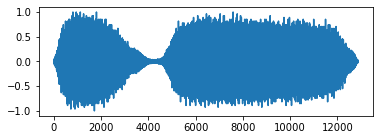

In [3]:
wavname = SAMPLE_WAV_URL
wavdata,sample_rate= audio.load(wavname)
# 
print(wavdata.shape, sample_rate)
fig = plt.figure(figsize=(6,2))
plt.plot(wavdata)
# if you want the plot above the audio widget, add line below
# plt.show()
display(Audio(data=wavdata,rate=sample_rate,autoplay=False,**Audio_args))

(449874,) 16000


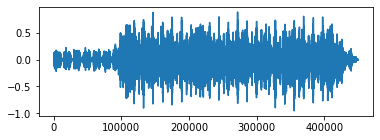

In [4]:
# You can specify a new sampling rate when reading in the data or convert multi to mono
# -- sample_rate=16000
# -- mono=True
wavname = SAMPLE_WAV_13dB_SNGER
#wavname = SAMPLE_WAV_URL
wavdata,sample_rate= audio.load(wavname,sample_rate=16000)
print(wavdata.shape, sample_rate)
fig = plt.figure(figsize=(6,2))
plt.plot(wavdata)
display(Audio(data=wavdata,rate=sample_rate,autoplay=False,**Audio_args))

## 2. Record from device

In [5]:
help(audio.record)

Help on function record in module pyspch.audio:

record(seconds=2.0, sample_rate=16000, n_channels=1)
    This routine checks the global variable _IO_ENV_, which is defined on loading
    the audio module, to know where to put output / get input  
    
    Parameters
    ----------
        seconds : float
            number of seconds to record (default=2.0)
        sample_rate : int
            sampling rate (default=16000)
        n_channels : int
            number of channels to record (default=1)
    
            
    Returns
    -------
        wavdata : float-32 array, shape (n_sample,_) or (n_channels, n_samples)
            the waveform data scaled to [-1., 1.]



In [11]:
# you can set sampling rate and number of channels to be recorded
requested_channels = 2
try:
    sd.check_input_settings(device=sd.default.device[0],channels=requested_channels)
    print("OK: number of requested channels is available")
except:
    print("Warning: requested number of input channels %d not available; change your request "
          % (requested_channels) )
    requested_channels = 1
sample_rate=16000
wavdata = audio.record(2.,sample_rate,n_channels=requested_channels)
print(wavdata.shape)

recording started for 2.00 seconds on 1 channel(s)
recording finished
(32000,)


In [13]:
# Remark that the IPython Audio object BY DEFAULT NORMALIZES the output
# The default **Audio_args will overcome that in versions of IPython (>=6) where normalization can be turned off
# Be careful, however, as the Audio module will crash on values exceeding +-1, there is no autoclipping
# Google Colab uses IPython 5.5 !!
# Record something in a soft voice and play both versions below for clear demonstration
if IPython.version_info[0] >= 6:
    display(Audio(data=wavdata,rate=sample_rate,normalize=False))
    display(Audio(data=wavdata,rate=sample_rate,normalize=True))
else:
    print("Warning: in IPython <6 you can only play normalized audio via the Browser !!")
    display(Audio(data=wavdata,rate=sample_rate))

## 3. Multichannel plot and play

In [14]:
# The plot_waveform() routine in the spectrogram module does proper multichannel plotting
#
# a note on librosa: waveform plotting can be display.waveform.waveplot() 
# though only channel by channel 
# > from librosa import display as libdisp
# > libdisp.waveplot(wavdata,sr=sample_rate)


In [15]:
wavdata.shape

(32000,)

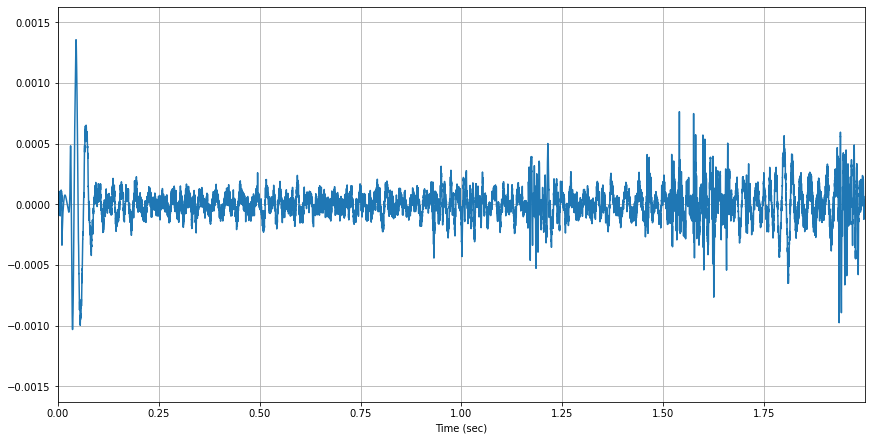

In [16]:
spch_disp.plot_waveform(wavdata,sample_rate=sample_rate)

In [ ]:
# just play the (stereo) waveform
# if you want to stage multiple sequential plays in a cell (or python code), 
# then you must wait for each of them to finish before starting the next one

# This will play all channels and wait for audio to finish
audio.play(wavdata,sample_rate=sample_rate,wait=True)

# This plays channel=0 and returns immediately 
audio.play(wavdata,sample_rate=sample_rate,channels=[0])


### 4. A mini recorder

In [17]:
Symbols = { 'play':'\u25b6','reverse':'\u25C0' , 'pause':'\u23F8', 'stop': '\u23F9', 'record':'\u2b55'}
def box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )
def button_layout():
    return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px',
        width = '40px',
        height = '40px',
        flex_shrink =2
     )

class mini_recorder(widgets.VBox):
    
    def __init__(self,data=np.zeros((1000,)),sample_rate=16000,figsize=(5,4),dpi=100):
        super().__init__()
        
        self.data = data
        
        self.sample_rate = sample_rate
        self.rec_time = 2.0         
        self.line_color = '#0000ff'
        self.figsize = figsize
        self.dpi = dpi
                     
        self.wg_play_button = widgets.Button(description=Symbols['play'],layout=button_layout())
        self.wg_record_button = widgets.Button(description=Symbols['record'],layout=button_layout())
        self.wg_pause_button = widgets.Button(description=Symbols['pause'],layout=button_layout())
        self.wg_clear_log_button = widgets.Button(description='Clear log')
        #self.rec_time_slider = widgets.FloatSlider(value=self.rec_time,step=.5,min=.5,max=10.,
        #                                           description='Rec Time',indent=False,continous_update=False)

        self.wg_rectime = widgets.BoundedFloatText(   value=2.0, min=0.5, max= 10., step=0.5,
            description='Rec Time:', disabled=False)
        self.out = widgets.Output(layout=box_layout())
        self.out.layout.width = '100%'
        self.logscr = widgets.Output()        
        self.UI = widgets.VBox([
            widgets.HBox([self.wg_play_button,self.wg_record_button,self.wg_pause_button,self.wg_rectime,self.wg_clear_log_button]),
            self.logscr], 
            layout=box_layout())
        self.UI.layout.width = '100%'
        # add as children
        self.children = [self.out, self.UI] 
        
        self.wg_play_button.on_click(self.play_sound)       
        self.wg_record_button.on_click(self.record_sound)
        self.wg_pause_button.on_click(self.pause_sound)
        self.wg_clear_log_button.on_click(self.clear_log)
        self.wg_rectime.observe(self.rectime_observe,'value')
        
        self.plot_data()
        plt.close()


    def plot_data(self):
        with self.out:
            clear_output(wait=True)
            spg = specg.spectrogram(self.data,sample_rate=self.sample_rate)
            self.fig = spch_disp.plot_spg(spg,wav=self.data,sample_rate=self.sample_rate,figsize=self.figsize,dpi=self.dpi)
            #self.fig = spch_disp.plot_waveform(self.data,sample_rate=self.sample_rate)
            display(self.fig)
        
    def rectime_observe(self,change):
        self.rec_time = change.new
    
    def pause_sound(self,b):
        with self.logscr:
            print("You didn't expect everything to work ?!! did you ... ")
            
    def play_sound(self,b):
        with self.logscr:
            clear_output()
            if(IN_COLAB):
              print("IN_COLAB: Use the HTML button to play sound")
            audio.play(self.data,sample_rate=self.sample_rate,wait=True)
        
    def record_sound(self,b):      
        with self.logscr:
            self.data = audio.record(self.rec_time,self.sample_rate,n_channels=1)
        self.plot_data()
        self.play_sound(b)
     
    def clear_log(self,b):
        with self.logscr: clear_output()
            


In [18]:
recorder = mini_recorder(figsize=(8,6))
recorder

mini_recorder(children=(Output(layout=Layout(border='solid 1px black', margin='0px 10px 10px 0px', padding='5p…

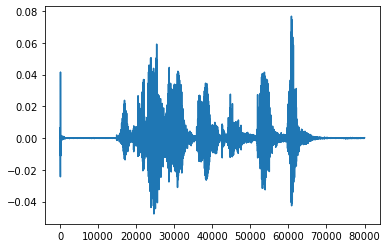

In [19]:
plt.plot(recorder.data)